# Google Play Store Reviews - Sentiment Analysis

Utilizing both traditional machine learning algorithms as well as deep learning approaches, the project, through natural language processing aims to classify Google Play Store reviews as positive, negative, or neutral, based on the text of the reviews, which were translated from a non-English language. The corpus of the text in the dataset was vectorized in two different ways. In addition, GloVe word embeddings were used to determine which text processing method produced the best metrics. An embedding layer was a central part of the model in the deep learning portion of the project. The metrics were compared to determine which text processing method as well as which algorithm resulted in the best model.

1. Import Libraries
2. Exploratory Data Analysis
3. Data Preprocessing and Visualizations
4. Classification Models using Count Vectorizer and TDIF Vectorizer
    1. Support Vector Machine
    2. Stochastic Gradient Descent
    3. XGBoost
5. Classification Models using GloVe Word Embeddings
    1. Stochastic Gradient Descent
    2. XGBoost
6. Classification Models with Deep Learning
    1. Embeddings from Corpus
    2. GloVe Word Embeddings

### Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

import regex as re
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from collections import Counter
from wordcloud import WordCloud

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras import utils
from keras.layers import Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import pickle as pkl
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import os

C:\Users\dytan\anaconda3\envs\tf\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Read Data

In [8]:
df = pd.read_csv('googleplaystore_user_reviews.csv', sep=',')

### Exploratory Data Analysis

In [3]:
df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     64295 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37432 non-null  object 
 3   Sentiment_Polarity      37432 non-null  float64
 4   Sentiment_Subjectivity  37432 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB


In [5]:
df['Sentiment'].unique()

array(['Positive', nan, 'Neutral', 'Negative'], dtype=object)

In [6]:
df['Sentiment'].value_counts(normalize=True)

Positive    0.641109
Negative    0.220961
Neutral     0.137930
Name: Sentiment, dtype: float64

In [9]:
df.drop(['App', 'Sentiment_Polarity', 'Sentiment_Subjectivity'], axis=1, inplace=True)
df.dropna(axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

,Translated_Review,Sentiment
0,I like eat delicious food. That's I'm cooking ...,Positive
1,This help eating healthy exercise regular basis,Positive
2,Works great especially going grocery store,Positive
3,Best idea us,Positive
4,Best way,Positive


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37427 entries, 0 to 37426
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Translated_Review  37427 non-null  object
 1   Sentiment          37427 non-null  object
dtypes: object(2)
memory usage: 584.9+ KB


In [9]:
print('First 10 reviews:\n')

for i in range(10):
    print(str(i+1) + ':', df.iloc[i]['Translated_Review'])

First 10 reviews:

1: I like eat delicious food. That's I'm cooking food myself, case "10 Best Foods" helps lot, also "Best Before (Shelf Life)"
2: This help eating healthy exercise regular basis
3: Works great especially going grocery store
4: Best idea us
5: Best way
6: Amazing
7: Looking forward app,
8: It helpful site ! It help foods get !
9: good you.
10: Useful information The amount spelling errors questions validity information shared. Once fixed, 5 stars given.


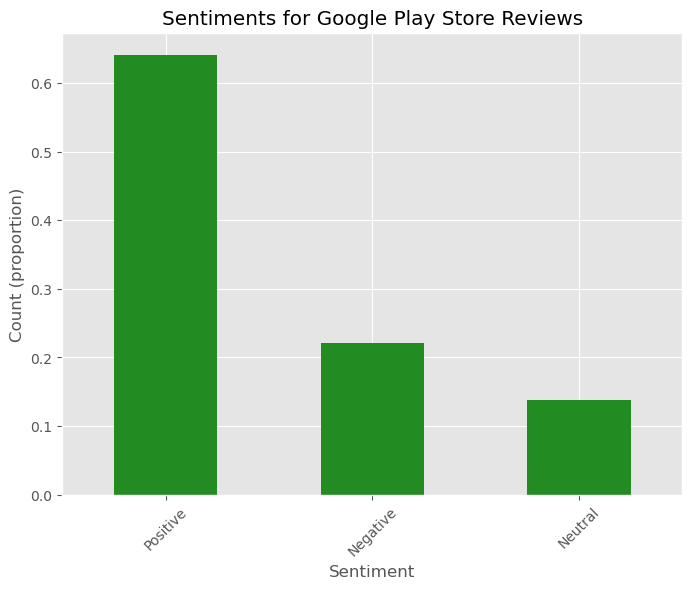

In [10]:
fig = plt.figure(figsize=(8,6))

df['Sentiment'].value_counts(normalize=True).plot(kind='bar', color='forestgreen')
plt.xlabel('Sentiment')
plt.ylabel('Count (proportion)')
plt.title('Sentiments for Google Play Store Reviews')
plt.xticks(rotation=45)
plt.show()

### Data Preprocessing and Visualizations

In [5]:
# function to process and clean text

REPLACE_HTML_RE = re.compile('https?://\s+|www\.\s+')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stop_words)

def clean_text(words):
    
    words = words.lower() # lowercase text
    words = REPLACE_BY_SPACE_RE.sub(' ', words) # replace REPLACE_BY_SPACE_RE symbols by space in text
    words = BAD_SYMBOLS_RE.sub('', words) # delete symbols which are in BAD_SYMBOLS_RE from text
    words = REPLACE_HTML_RE.sub('', words) # delete html address
    words = ' '.join(word for word in words.split() if word not in STOPWORDS) # delete stopwords from text
    return words

In [12]:
X = df['Translated_Review'].apply(clean_text)

In [6]:
# function to remove emojis

def remove_emoji(words):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', words)

In [14]:
X = X.apply(remove_emoji)

In [15]:
X.head()

0    like eat delicious food thats im cooking food ...
1           help eating healthy exercise regular basis
2           works great especially going grocery store
3                                         best idea us
4                                             best way
Name: Translated_Review, dtype: object

In [16]:
corpus = []

for row in tqdm(range(len(X))):
    for word in X.iloc[row].split():
        corpus.append(word)

corpus[0:20]

100%|██████████| 37427/37427 [00:00<00:00, 82933.21it/s]


['like',
 'eat',
 'delicious',
 'food',
 'thats',
 'im',
 'cooking',
 'food',
 'case',
 '10',
 'best',
 'foods',
 'helps',
 'lot',
 'also',
 'best',
 'shelf',
 'life',
 'help',
 'eating']

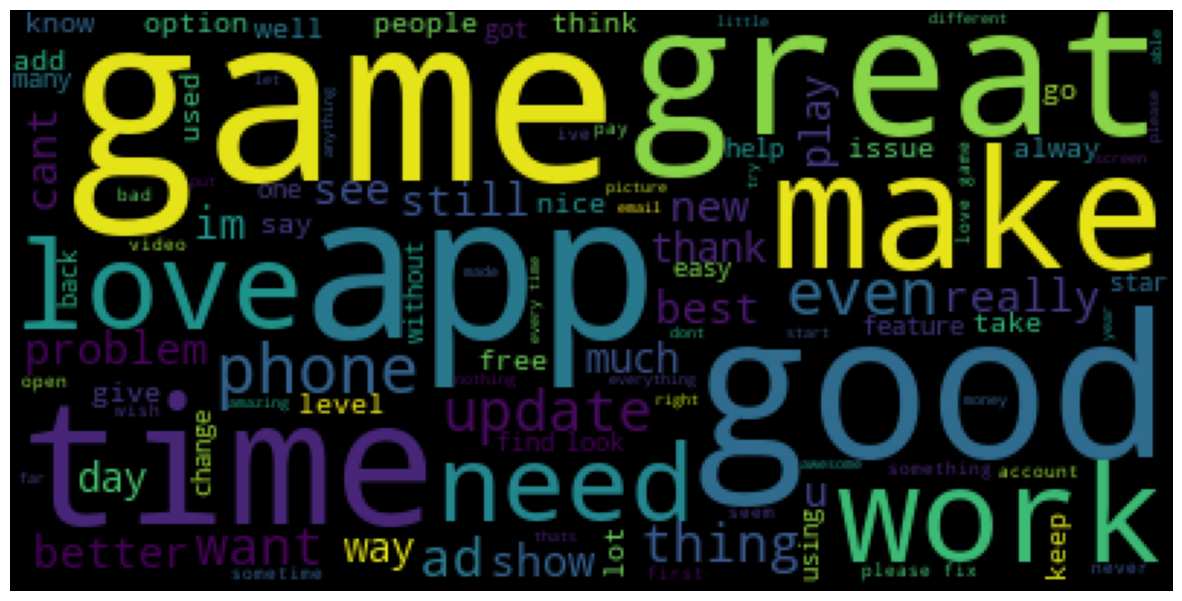

In [17]:
fig = plt.figure(figsize=(15,12))
word_cloud = WordCloud(background_color='black', max_font_size=80, max_words=100).generate(' '.join(corpus))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [18]:
# tokenize text in corpus

from nltk.tokenize import TreebankWordTokenizer

tokenizer = TreebankWordTokenizer()

for i in tqdm(range(len(X.values))):
    X.values[i] = tokenizer.tokenize(X.values[i])
    
X.head()

100%|██████████| 37427/37427 [00:02<00:00, 12563.90it/s]


0    [like, eat, delicious, food, thats, im, cookin...
1    [help, eating, healthy, exercise, regular, basis]
2    [works, great, especially, going, grocery, store]
3                                     [best, idea, us]
4                                          [best, way]
Name: Translated_Review, dtype: object

In [19]:
counter = Counter()

for i in tqdm(range(len(X))):
    for word in X[i]:
        counter[word] += 1

counter = dict(counter)

100%|██████████| 37427/37427 [00:00<00:00, 89968.00it/s]


In [20]:
# retrieve 10 most frequent words in corpus

from operator import itemgetter

top_10_words = dict(sorted(counter.items(), key = itemgetter(1), reverse = True)[:10])
words = [x for x in top_10_words.keys()]
counts = [x for x in top_10_words.values()]
data = {'words': words, 'counts': counts}
top_10_words = pd.DataFrame(data, columns=['words', 'counts'])
top_10_words

,words,counts
0,game,9288
1,like,5478
2,good,5243
3,app,4812
4,great,4798
5,get,4716
6,love,4658
7,time,4478
8,would,3372
9,cant,3113


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


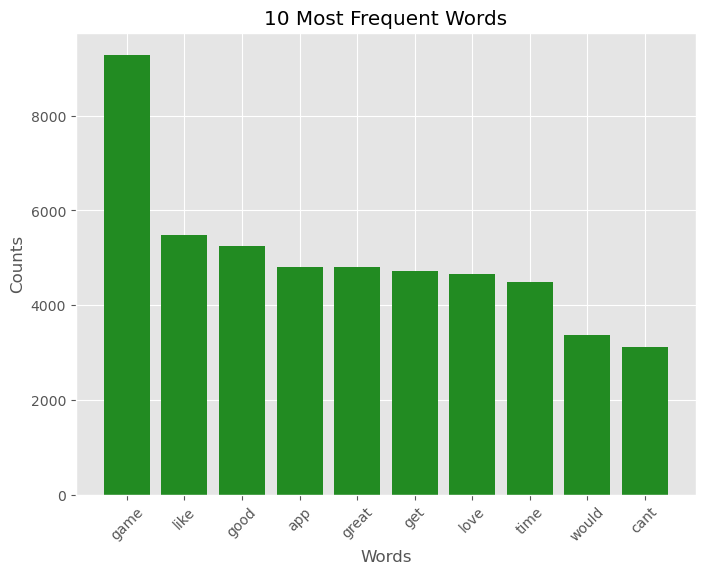

In [21]:
# plot 10 most frequent words in corpus

fig = plt.figure(figsize=(8,6))
plt.bar(top_10_words['words'], top_10_words['counts'], color='forestgreen')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.title('10 Most Frequent Words')
plt.legend().set_visible(False)
plt.show()

In [22]:
for i in tqdm(range(len(X.values))):
    X.values[i] = ' '.join(X.values[i]) 

100%|██████████| 37427/37427 [00:00<00:00, 306046.08it/s]


In [23]:
df['Translated_Review'].head()

0    I like eat delicious food. That's I'm cooking ...
1      This help eating healthy exercise regular basis
2           Works great especially going grocery store
3                                         Best idea us
4                                             Best way
Name: Translated_Review, dtype: object

In [24]:
X.head()

0    like eat delicious food thats im cooking food ...
1           help eating healthy exercise regular basis
2           works great especially going grocery store
3                                         best idea us
4                                             best way
Name: Translated_Review, dtype: object

In [25]:
le = LabelEncoder()
y = le.fit_transform(df['Sentiment'])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=108,
                                                   test_size=0.2, shuffle=True)

In [27]:
cv = CountVectorizer(min_df=2, max_df=0.85, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}', 
                     ngram_range=(1,3), stop_words='english')

cv.fit(list(X_train) + list(X_test))
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

In [28]:
tfv = TfidfVectorizer(min_df=2, max_df=0.85, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}', 
                     ngram_range=(1,3), stop_words='english')

tfv.fit(list(X_train) + list(X_test))
X_train_tfv = tfv.transform(X_train)
X_test_tfv = tfv.transform(X_test)

In [29]:
print('Dimensions of Count Vectorizer train set: {}.'.format(X_train_cv.shape))
print('Dimensions of Count Vectorizer test set: {}.'.format(X_test_cv.shape))
print('Dimensions of TFIDF Vectorizer train set: {}.'.format(X_train_tfv.shape))
print('Dimensions of TFIDF Vectorizer test set: {}.'.format(X_test_tfv.shape))

Dimensions of Count Vectorizer train set: (29941, 168244).
Dimensions of Count Vectorizer test set: (7486, 168244).
Dimensions of TFIDF Vectorizer train set: (29941, 168244).
Dimensions of TFIDF Vectorizer test set: (7486, 168244).


In [30]:
def plot_LSA(test_data, test_labels, title, plot=True):
    
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label: idx for idx, label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ['blue', 'red', 'orange']
    if plot:
        plt.figure(figsize=(10,8))
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=25, alpha=0.5, c=test_labels,
                    cmap=matplotlib.colors.ListedColormap(colors))
        blue_patch = mpatches.Patch(color='blue', label='Positive')
        red_patch = mpatches.Patch(color='red', label='Negative')
        orange_patch = mpatches.Patch(color='orange', label='Neutral')
        plt.legend(handles=[blue_patch, red_patch, orange_patch], prop={'size': 10})
        plt.title(title)

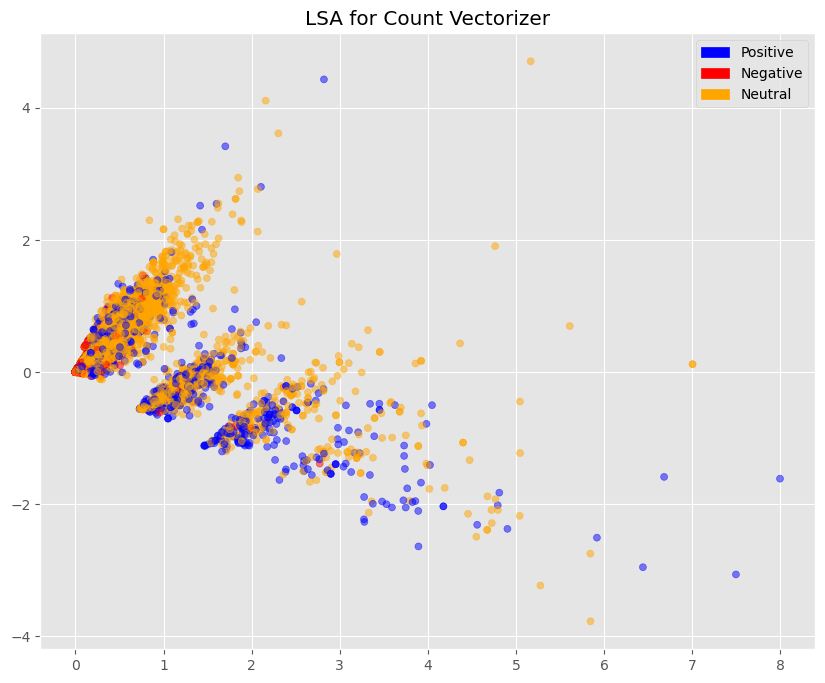

In [31]:
plot_LSA(X_test_cv, y_test, title='LSA for Count Vectorizer')

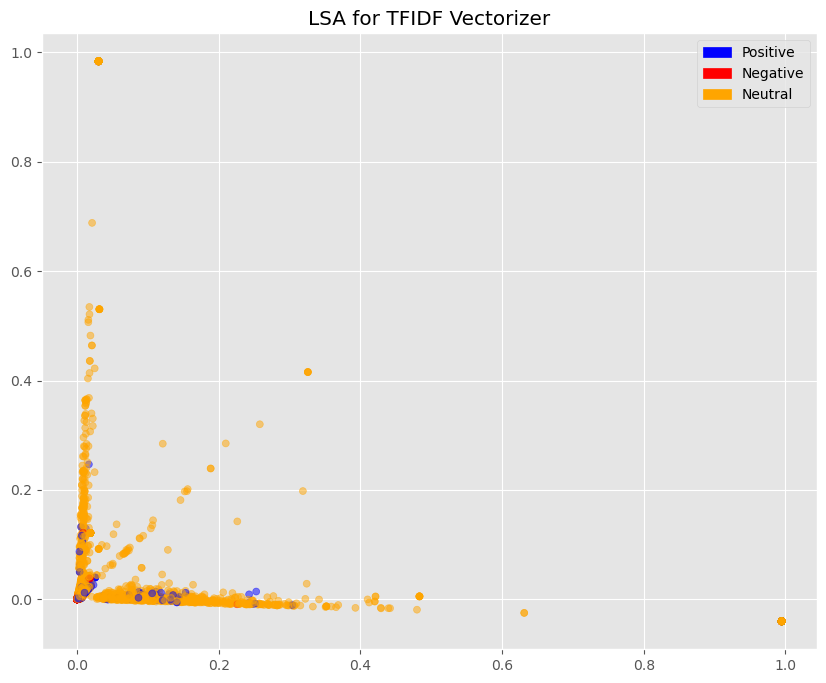

In [32]:
plot_LSA(X_test_tfv, y_test, title='LSA for TFIDF Vectorizer')

### Classification Models

#### Support Vector Classifier

In [33]:
# decomposition for count vectorizer

svd_cv = TruncatedSVD(n_components=120)
svd_cv.fit(X_train_cv)
X_train_cv_svd = svd_cv.transform(X_train_cv)
X_test_cv_svd = svd_cv.transform(X_test_cv)

In [34]:
# decomposition for tfidf vectorizer

svd_tfv = TruncatedSVD(n_components=120)
svd_tfv.fit(X_train_tfv)
X_train_tfv_svd = svd_tfv.transform(X_train_tfv)
X_test_tfv_svd = svd_tfv.transform(X_test_tfv)

Model using count vectorized data

In [35]:
# scale count vectorizer

scl = StandardScaler()
scl.fit(X_train_cv_svd)
X_train_cv_svd_scl = scl.transform(X_train_cv_svd)
X_test_cv_svd_scl = scl.transform(X_test_cv_svd)

In [36]:
svm_cv = SVC()

C = [1.0, 2.0, 4.0]
gamma = ['scale', 'auto']
param_grid = {'C': C, 'gamma': gamma}

svm_cv = GridSearchCV(svm_cv, param_grid)

In [37]:
svm_cv.fit(X_train_cv_svd_scl, y_train)
svm_pred_cv = svm_cv.predict(X_test_cv_svd_scl)
print(classification_report(y_test, svm_pred_cv))

              precision    recall  f1-score   support

           0       0.77      0.64      0.70      1654
           1       0.60      0.82      0.69      1032
           2       0.90      0.88      0.89      4800

    accuracy                           0.82      7486
   macro avg       0.75      0.78      0.76      7486
weighted avg       0.83      0.82      0.82      7486



In [38]:
print(svm_cv.best_estimator_)
print(svm_cv.best_params_)

SVC(C=4.0)
{'C': 4.0, 'gamma': 'scale'}


In [39]:
pkl.dump(svm_cv, open('svm_cv.pkl', 'wb'))

In [40]:
svm = pkl.load(open('svm_cv.pkl', 'rb'))

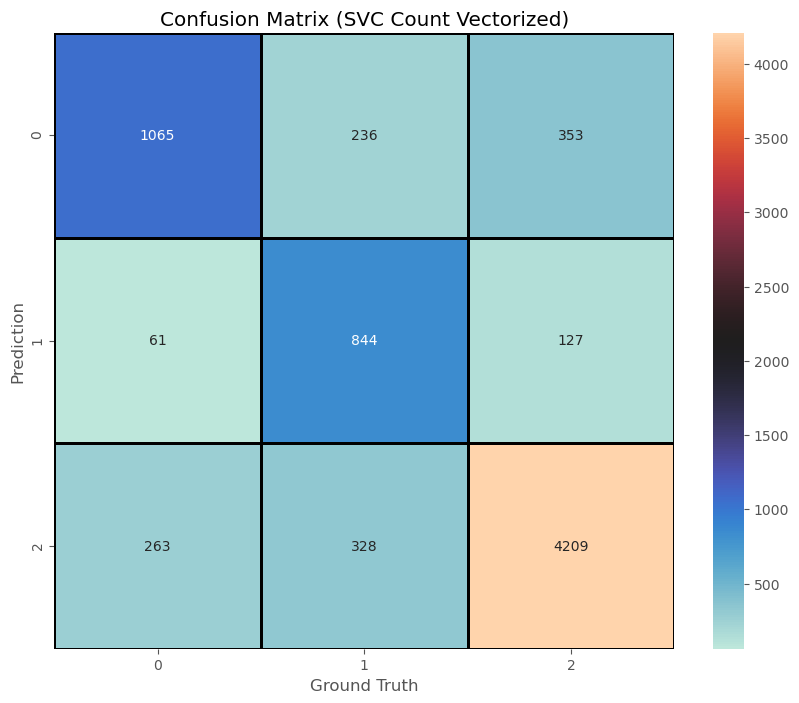

In [41]:
cm = confusion_matrix(y_test, svm_pred_cv)

fig = plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='icefire', linecolor='black', linewidths=1, fmt='d')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title('Confusion Matrix (SVC Count Vectorized)')
plt.show()

Model using TFIDF vectorized data

In [42]:
# scale tfidf vectorizer

scl = StandardScaler()
scl.fit(X_train_tfv_svd)
X_train_tfv_svd_scl = scl.transform(X_train_tfv_svd)
X_test_tfv_svd_scl = scl.transform(X_test_tfv_svd)

In [43]:
svm_tfv = SVC()

C = [1.0, 2.0, 4.0]
gamma = ['scale', 'auto']
param_grid = {'C': C, 'gamma': gamma}

svm_tfv = GridSearchCV(svm_tfv, param_grid)

In [44]:
svm_tfv.fit(X_train_tfv_svd_scl, y_train)
svm_pred_tfv = svm_tfv.predict(X_test_tfv_svd_scl)
print(classification_report(y_test, svm_pred_tfv))

              precision    recall  f1-score   support

           0       0.76      0.66      0.71      1654
           1       0.69      0.71      0.70      1032
           2       0.87      0.91      0.89      4800

    accuracy                           0.83      7486
   macro avg       0.77      0.76      0.77      7486
weighted avg       0.82      0.83      0.82      7486



In [45]:
print(svm_tfv.best_estimator_)
print(svm_tfv.best_params_)

SVC(C=4.0)
{'C': 4.0, 'gamma': 'scale'}


In [46]:
pkl.dump(svm_tfv, open('svm_tfv.pkl', 'wb'))

In [47]:
svm_tfv = pkl.load(open('svm_tfv.pkl', 'rb'))

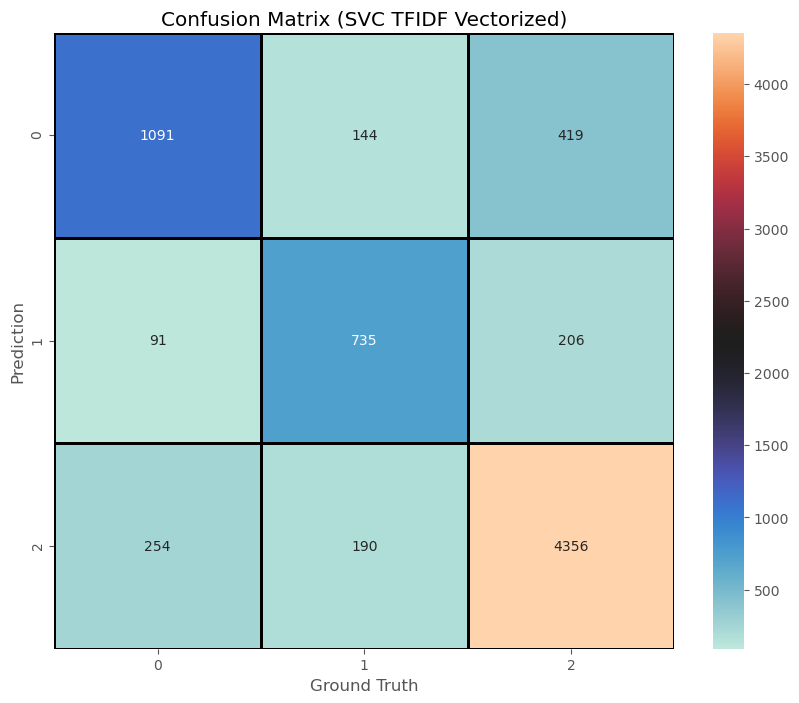

In [48]:
cm = confusion_matrix(y_test, svm_pred_tfv)

fig = plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='icefire', linecolor='black', linewidths=1, fmt='d')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title('Confusion Matrix (SVC TFIDF Vectorized)')
plt.show()

#### Stochastic Gradient Descent Classifier

Model using count vectorized data

In [49]:
sgd_cv = SGDClassifier()

loss = ['hinge', 'log']
alpha = [0.01, 0.001, 0.0001]
max_iter = [500, 1000, 2000]

params_grid = {'loss': loss, 'alpha': alpha, 'max_iter': max_iter}
sgd_cv = GridSearchCV(sgd_cv, params_grid, verbose=0)

In [50]:
sgd_cv.fit(X_train_cv, y_train)
sgd_pred_cv = sgd_cv.predict(X_test_cv)
print(classification_report(y_test, sgd_pred_cv))

              precision    recall  f1-score   support

           0       0.91      0.86      0.89      1654
           1       0.81      0.93      0.87      1032
           2       0.96      0.95      0.95      4800

    accuracy                           0.93      7486
   macro avg       0.89      0.91      0.90      7486
weighted avg       0.93      0.93      0.93      7486



In [51]:
print(sgd_cv.best_estimator_)
print(sgd_cv.best_params_)

SGDClassifier(max_iter=2000)
{'alpha': 0.0001, 'loss': 'hinge', 'max_iter': 2000}


In [52]:
pkl.dump(sgd_cv, open('sgd_cv.pkl', 'wb'))

In [53]:
sgd_cv = pkl.load(open('sgd_cv.pkl', 'rb'))

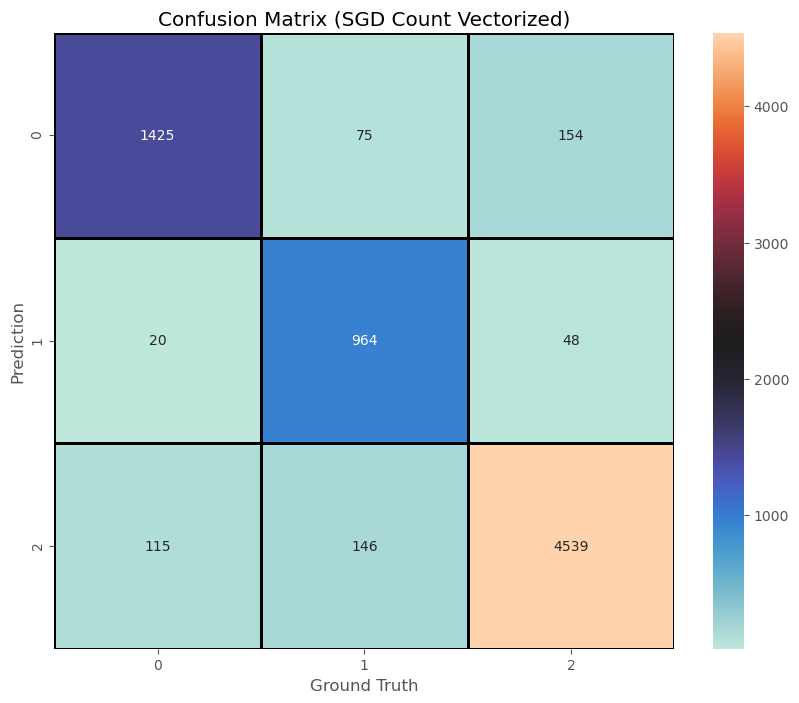

In [54]:
cm = confusion_matrix(y_test, sgd_pred_cv)

fig = plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='icefire', linecolor='black', linewidths=1, fmt='d')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title('Confusion Matrix (SGD Count Vectorized)')
plt.show()

Model using TFIDF vectorized data

In [55]:
sgd_tfv = SGDClassifier()

loss = ['hinge', 'log']
alpha = [0.01, 0.001, 0.0001]
max_iter = [500, 1000, 2000]

params_grid = {'loss': loss, 'alpha': alpha, 'max_iter': max_iter}
sgd_tfv = GridSearchCV(sgd_tfv, params_grid, verbose=0)

In [56]:
sgd_tfv.fit(X_train_tfv, y_train)
sgd_pred_tfv = sgd_tfv.predict(X_test_tfv)
print(classification_report(y_test, sgd_pred_tfv))

              precision    recall  f1-score   support

           0       0.93      0.76      0.83      1654
           1       0.90      0.55      0.68      1032
           2       0.85      0.98      0.91      4800

    accuracy                           0.87      7486
   macro avg       0.89      0.76      0.81      7486
weighted avg       0.88      0.87      0.86      7486



In [57]:
print(sgd_tfv.best_estimator_)
print(sgd_tfv.best_params_)

SGDClassifier(max_iter=500)
{'alpha': 0.0001, 'loss': 'hinge', 'max_iter': 500}


In [58]:
pkl.dump(sgd_tfv, open('sgd_tfv.pkl', 'wb'))

In [59]:
sgd_tfv = pkl.load(open('sgd_tfv.pkl', 'rb'))

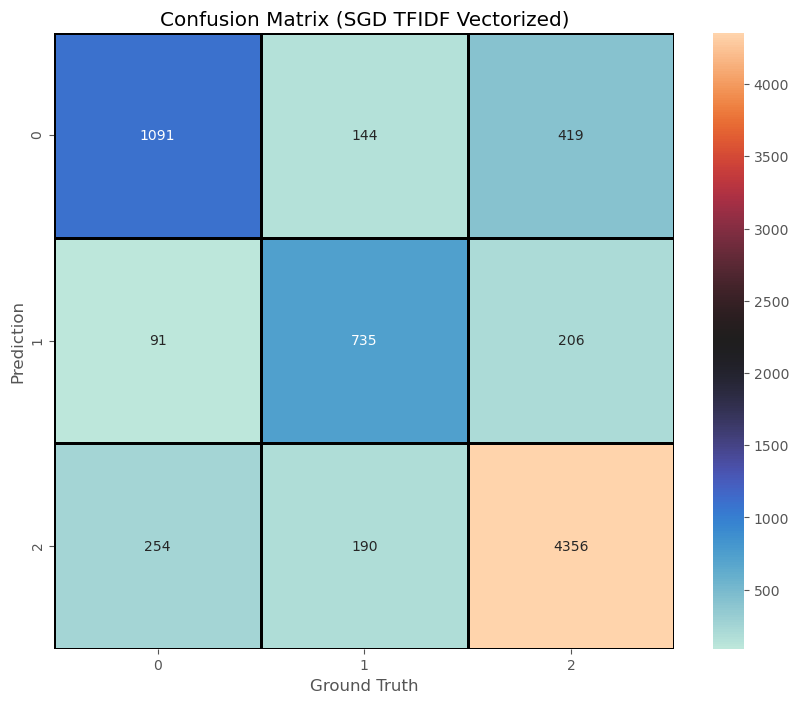

In [60]:
cm = confusion_matrix(y_test, svm_pred_tfv)

fig = plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='icefire', linecolor='black', linewidths=1, fmt='d')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title('Confusion Matrix (SGD TFIDF Vectorized)')
plt.show()

#### XGBoost Classifier

Model using count vectorized data

In [61]:
XGB_cv = xgb.XGBClassifier(verbosity=0)

gamma = [0, 1, 3]
max_depth = [4, 6, 8]
subsample = [0.5, 0.75, 1]
params_grid = {'gamma': gamma, 'max_depth': max_depth, 'subsample': subsample}

XGB_cv = GridSearchCV(XGB_cv, params_grid)

In [62]:
XGB_cv.fit(X_train_cv, y_train)
XGB_pred_cv = XGB_cv.predict(X_test_cv)
print(classification_report(y_test, XGB_pred_cv))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86      1654
           1       0.76      0.92      0.84      1032
           2       0.94      0.93      0.94      4800

    accuracy                           0.91      7486
   macro avg       0.87      0.89      0.88      7486
weighted avg       0.91      0.91      0.91      7486



In [63]:
print(XGB_cv.best_estimator_)
print(XGB_cv.best_params_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.75, tree_method='exact', validate_parameters=1,
              verbosity=0)
{'gamma': 0, 'max_depth': 8, 'subsample': 0.75}


In [64]:
pkl.dump(XGB_cv, open('xgb_cv.pkl', 'wb'))

In [65]:
XGB_cv = pkl.load(open('xgb_cv.pkl', 'rb'))

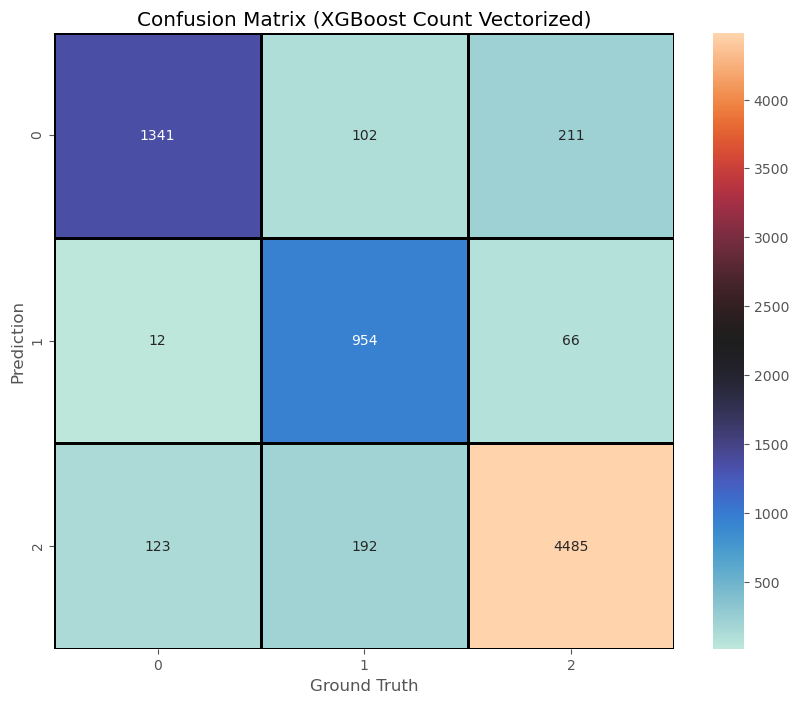

In [66]:
cm = confusion_matrix(y_test, XGB_pred_cv)

fig = plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='icefire', linecolor='black', linewidths=1, fmt='d')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title('Confusion Matrix (XGBoost Count Vectorized)')
plt.show()

Model using TFIDF vectorized data

In [67]:
XGB_tfv = xgb.XGBClassifier(verbosity=0)

gamma = [0, 1, 3]
max_depth = [4, 6, 8]
subsample = [0.5, 0.75, 1]
params_grid = {'gamma': gamma, 'max_depth': max_depth, 'subsample': subsample}

XGB_tfv = GridSearchCV(XGB_tfv, params_grid)

In [68]:
XGB_tfv.fit(X_train_tfv, y_train)
XGB_pred_tfv = XGB_tfv.predict(X_test_tfv)
print(classification_report(y_test, XGB_pred_tfv))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85      1654
           1       0.77      0.94      0.85      1032
           2       0.94      0.93      0.94      4800

    accuracy                           0.91      7486
   macro avg       0.87      0.89      0.88      7486
weighted avg       0.91      0.91      0.91      7486



In [69]:
print(XGB_tfv.best_estimator_)
print(XGB_tfv.best_params_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=0)
{'gamma': 0, 'max_depth': 8, 'subsample': 1}


In [70]:
pkl.dump(XGB_tfv, open('xgb_tfv.pkl', 'wb'))

In [71]:
XGB_tfv = pkl.load(open('xgb_tfv.pkl', 'rb'))

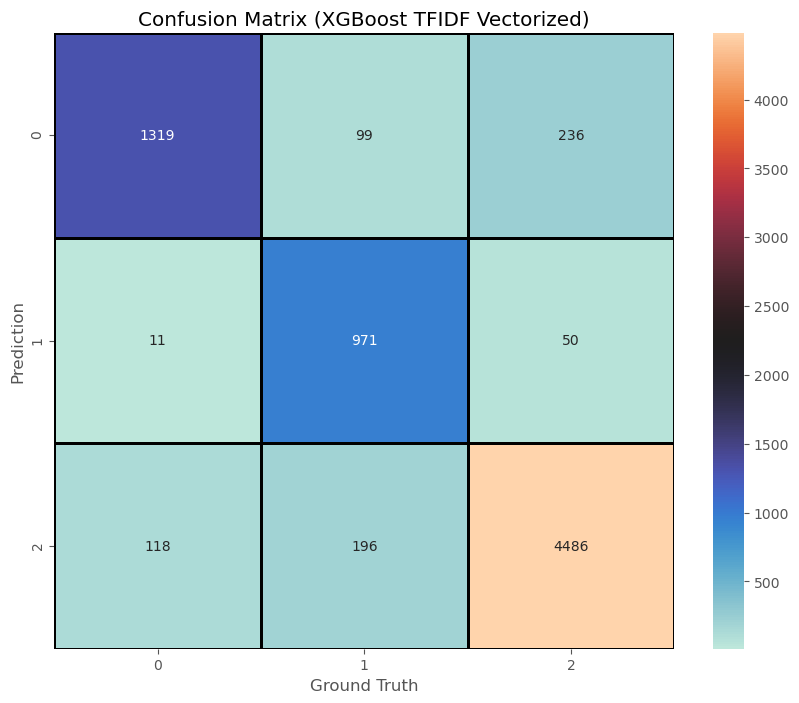

In [72]:
cm = confusion_matrix(y_test, XGB_pred_tfv)

fig = plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='icefire', linecolor='black', linewidths=1, fmt='d')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title('Confusion Matrix (XGBoost TFIDF Vectorized)')
plt.show()

### GloVe Embeddings

In [73]:
os.listdir()

['.ipynb_checkpoints',
 'embeddings_index.pkl',
 'glove.840B.300d.txt',
 'Google Play Store.ipynb',
 'googleplaystore.csv',
 'googleplaystore_user_reviews.csv',
 'license.txt',
 'lr_grid.pkl',
 'Model 1 Accuracy and Loss.png',
 'Model 2 Accuracy and Loss.png',
 'Model Corpus Accuracy and Loss.png',
 'Model GloVe.png',
 'model_1.h5',
 'model_1.json',
 'model_2.h5',
 'model_2.json',
 'sgd.pkl',
 'sgd_cv.pkl',
 'sgd_glove.pkl',
 'sgd_grid.pkl',
 'sgd_tfv.pkl',
 'svm.pkl',
 'svm_1.pkl',
 'svm_cv.pkl',
 'svm_tfv.pkl',
 'xgb.pkl',
 'xgb_cv.pkl',
 'xgb_glove.pkl',
 'xgb_tfv.pkl',
 'X_cleaned.pkl',
 'X_test.pkl',
 'x_test_glove.pkl',
 'X_train.pkl',
 'x_train_glove.pkl',
 'y.pkl']

In [74]:
text = pd.read_table('glove.840B.300d.txt')
text.head()

,", -0.082752 0.67204 -0.14987 -0.064983 0.056491 0.40228 0.0027747 -0.3311 -0.30691 2.0817 0.031819 0.013643 0.30265 0.0071297 -0.5819 -0.2774 -0.062254 1.1451 -0.24232 0.1235 -0.12243 0.33152 -0.006162 -0.30541 -0.13057 -0.054601 0.037083 -0.070552 0.5893 -0.30385 0.2898 -0.14653 -0.27052 0.37161 0.32031 -0.29125 0.0052483 -0.13212 -0.052736 0.087349 -0.26668 -0.16897 0.015162 -0.0083746 -0.14871 0.23413 -0.20719 -0.091386 0.40075 -0.17223 0.18145 0.37586 -0.28682 0.37289 -0.16185 0.18008 0.3032 -0.13216 0.18352 0.095759 0.094916 0.008289 0.11761 0.34046 0.03677 -0.29077 0.058303 -0.027814 0.082941 0.1862 -0.031494 0.27985 -0.074412 -0.13762 -0.21866 0.18138 0.040855 -0.113 0.24107 0.3657 -0.27525 -0.05684 0.34872 0.011884 0.14517 -0.71395 0.48497 0.14807 0.62287 0.20599 0.58379 -0.13438 0.40207 0.18311 0.28021 -0.42349 -0.25626 0.17715 -0.54095 0.16596 -0.036058 0.08499 -0.64989 0.075549 -0.28831 0.40626 -0.2802 0.094062 0.32406 0.28437 -0.26341 0.11553 0.071918 -0.47215 -0.18366 -0.34709 0.29964 -0.66514 0.002516 -0.42333 0.27512 0.36012 0.16311 0.23964 -0.05923 0.3261 0.20559 0.038677 -0.045816 0.089764 0.43151 -0.15954 0.08532 -0.26572 -0.15001 0.084286 -0.16714 -0.43004 0.060807 0.13121 -0.24112 0.66554 0.4453 -0.18019 -0.13919 0.56252 0.21457 -0.46443 -0.012211 0.029988 -0.051094 -0.20135 0.80788 0.47377 -0.057647 0.46216 0.16084 -0.20954 -0.05452 0.15572 -0.13712 0.12972 -0.011936 -0.003378 -0.13595 -0.080711 0.20065 0.054056 0.046816 0.059539 0.046265 0.17754 -0.31094 0.28119 -0.24355 0.085252 -0.21011 -0.19472 0.0027297 -0.46341 0.14789 -0.31517 -0.065939 0.036106 0.42903 -0.33759 0.16432 0.32568 -0.050392 -0.054297 0.24074 0.41923 0.13012 -0.17167 -0.37808 -0.23089 -0.019477 -0.29291 -0.30824 0.30297 -0.22659 0.081574 -0.18516 -0.21408 0.40616 -0.28974 0.074174 -0.17795 0.28595 -0.039626 -0.2339 -0.36054 -0.067503 -0.091065 0.23438 -0.0041331 0.003232 0.0072134 0.008697 0.21614 0.049904 0.35582 0.13748 0.073361 0.14166 0.2412 -0.013322 0.15613 0.083381 0.088146 -0.019357 0.43795 0.083961 0.45309 -0.50489 -0.10865 -0.2527 -0.18251 0.20441 0.13319 0.1294 0.050594 -0.15612 -0.39543 0.12538 0.24881 -0.1927 -0.31847 -0.12719 0.4341 0.31177 -0.0040946 -0.2094 -0.079961 0.1161 -0.050794 0.015266 -0.2803 -0.12486 0.23587 0.2339 -0.14023 0.028462 0.56923 -0.1649 -0.036429 0.010051 -0.17107 -0.042608 0.044965 -0.4393 -0.26137 0.30088 -0.060772 -0.45312 -0.19076 -0.20288 0.27694 -0.060888 0.11944 0.62206 -0.19343 0.47849 -0.30113 0.059389 0.074901 0.061068 -0.4662 0.40054 -0.19099 -0.14331 0.018267 -0.18643 0.20709 -0.35598 0.05338 -0.050821 -0.1918 -0.37846 -0.06589"
0,. 0.012001 0.20751 -0.12578 -0.59325 0.12525 0...
1,the 0.27204 -0.06203 -0.1884 0.023225 -0.01815...
2,and -0.18567 0.066008 -0.25209 -0.11725 0.2651...
3,to 0.31924 0.06316 -0.27858 0.2612 0.079248 -0...
4,of 0.060216 0.21799 -0.04249 -0.38618 -0.15388...


In [75]:
# create embeddings index from GloVe word vectors

GLOVE_DATASET_PATH = 'glove.840B.300d.txt'
dictionary = set(corpus)

embeddings_index = {}
f = open(GLOVE_DATASET_PATH, encoding='utf8')

for line in tqdm(f):
    try:
        values = line.split()
        word = values[0]
        if word in dictionary:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
  
    except:
        values = line.split()
        word = ". . ."
        if word in dictionary:
            coefs = np.asarray(values[3:], dtype='float32')
            embeddings_index[word] = coefs

f.close()

2196017it [01:09, 31441.18it/s]


In [76]:
pkl.dump(embeddings_index, open('embeddings_index.pkl', 'wb'))

In [20]:
embeddings_index = pkl.load(open('embeddings_index.pkl', 'rb'))

In [78]:
print('Size of GloVe embeddings index:', len(embeddings_index))
print('Sample of embedding for "good":', embeddings_index['good'])
print('Length of embedding for "good:', len(embeddings_index['good']))

Size of GloVe embeddings index: 19554
Sample of embedding for "good": [-0.42625    0.4431    -0.34517   -0.1326    -0.05816    0.052598
  0.21575   -0.36721   -0.04519    2.2444    -0.29089    0.1667
 -0.052051   0.15964   -0.42759   -0.11147   -0.14951    1.18
 -0.19603    0.15592   -0.06112   -0.011576   0.26849   -0.30175
 -0.055796   0.12116    0.010542  -0.18065    0.23281   -0.26367
  0.11032    0.06216    0.015019  -0.10687    0.098486   0.048457
  0.33355   -0.16177   -0.28503   -0.28655   -0.11245    0.12417
 -0.24975   -0.2008     0.26034    0.25208   -0.17841    0.15395
 -0.19799   -0.22644   -0.074088   0.50289    0.32105   -0.034766
  0.16543    0.057095  -0.20973    0.098376   0.035058  -0.023057
 -0.11736   -0.51327   -0.020999   0.39962    0.30533   -0.38839
  0.0026097  0.29022    0.017045   0.063961   0.10789    0.29013
  0.061732   0.068231  -0.014031   0.048649  -0.011663  -0.26527
 -0.14494    0.45397    0.067191   0.14195    0.37302   -0.0076579
  0.018443  -0.102

In [79]:
# function for word vector for whole sentence

def sent2vec(s):
    words = s.split()
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = np.sum(M, axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    else:
        return v / np.sqrt((v**2).sum())

In [80]:
X_train_glove = np.array([sent2vec(x) for x in tqdm(X_train)])
X_test_glove = np.array([sent2vec(x) for x in tqdm(X_test)])

100%|██████████| 7486/7486 [00:00<00:00, 22508.99it/s]


In [81]:
pkl.dump(X_train_glove, open('x_train_glove.pkl', 'wb'))
pkl.dump(X_test_glove, open('x_test_glove.pkl', 'wb'))

In [82]:
X_train_glove = pkl.load(open('x_train_glove.pkl', 'rb'))
X_test_glove = pkl.load(open('x_test_glove.pkl', 'rb'))

In [83]:
print('Shape of GloVe train set:', X_train_glove.shape)
print('Shape of GloVe test set:', X_test_glove.shape)
print('Size of train labels:', len(y_train))
print('Size of test labels:', len(y_test))
print('Size of sample word vector:', len(X_train_glove[0]))
print('Data type of first item in GloVe train set:', type(X_train_glove[0]))
print('First item in GloVe train set:', X_train_glove[0])

Shape of GloVe train set: (29941, 300)
Shape of GloVe test set: (7486, 300)
Size of train labels: 29941
Size of test labels: 7486
Size of sample word vector: 300
Data type of first item in GloVe train set: <class 'numpy.ndarray'>
First item in GloVe train set: [-4.83554304e-02  4.50481176e-02 -7.09628761e-02 -4.11319658e-02
 -2.68227328e-02  1.56888906e-02  9.29144304e-03 -1.00315154e-01
  3.58961783e-02  5.05243480e-01 -4.52591367e-02  1.62351541e-02
 -4.60362099e-02 -4.26182896e-02 -3.31198564e-03  2.24050786e-03
  5.42364921e-03  2.36593649e-01 -3.23060155e-02  2.60757003e-02
  3.26658748e-02  2.23826263e-02 -1.02611519e-02 -4.98737209e-02
  2.57704351e-02 -2.41714716e-02 -2.29015909e-02 -3.77218463e-02
  7.94498473e-02  2.00193338e-02 -1.58652067e-02  4.72685248e-02
 -2.69561466e-02  1.64828338e-02  1.85562335e-02  2.57791020e-02
 -2.00983137e-02 -3.06592155e-02 -3.95483263e-02  3.14103104e-02
 -6.96283579e-02 -4.16718163e-02 -6.41700476e-02 -7.04861246e-03
 -2.16892716e-02  2.0625

#### SGD Classifier

In [84]:
sgd_glove = SGDClassifier()

loss = ['hinge', 'log']
alpha = [0.01, 0.001, 0.0001]
max_iter = [500, 1000, 2000]

params_grid = {'loss': loss, 'alpha': alpha, 'max_iter': max_iter}
sgd_glove = GridSearchCV(sgd_glove, params_grid, verbose=0)

In [85]:
sgd_glove.fit(X_train_glove, y_train)
sgd_glove_pred = sgd_glove.predict(X_test_glove)
print(classification_report(y_test, sgd_glove_pred))

              precision    recall  f1-score   support

           0       0.76      0.54      0.64      1654
           1       0.79      0.54      0.64      1032
           2       0.81      0.95      0.87      4800

    accuracy                           0.80      7486
   macro avg       0.79      0.68      0.72      7486
weighted avg       0.80      0.80      0.79      7486



In [86]:
print(sgd_glove.best_estimator_)
print(sgd_glove.best_params_)

SGDClassifier()
{'alpha': 0.0001, 'loss': 'hinge', 'max_iter': 1000}


In [87]:
pkl.dump(sgd_glove, open('sgd_glove.pkl', 'wb'))

In [88]:
sgd_glove = pkl.load(open('sgd_glove.pkl', 'rb'))

Text(0.5, 1.0, 'Confusion Matrix (SGD GloVe)')

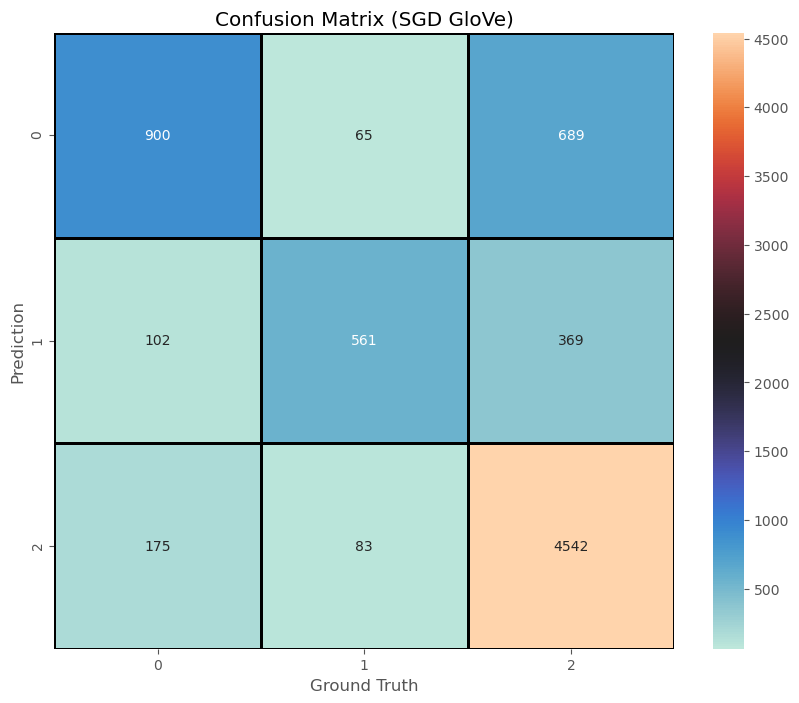

In [89]:
cm = confusion_matrix(y_test, sgd_glove_pred)

fig = plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='icefire', linecolor='black', linewidths=1, fmt='d')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title('Confusion Matrix (SGD GloVe)')

#### XGBoost Classifier

In [90]:
XGB_glove = xgb.XGBClassifier(verbosity=0)

gamma = [0, 1, 3]
max_depth = [4, 6, 8]
subsample = [0.5, 0.75, 1]
params_grid = {'gamma': gamma, 'max_depth': max_depth, 'subsample': subsample}

XGB_glove = GridSearchCV(XGB_glove, params_grid)

In [92]:
XGB_glove.fit(X_train_glove, y_train)
XGB_glove_pred = XGB_glove.predict(X_test_glove)
print(classification_report(y_test, XGB_glove_pred))

              precision    recall  f1-score   support

           0       0.83      0.73      0.78      1654
           1       0.80      0.69      0.74      1032
           2       0.88      0.94      0.91      4800

    accuracy                           0.86      7486
   macro avg       0.84      0.79      0.81      7486
weighted avg       0.86      0.86      0.86      7486



In [93]:
print(XGB_glove.best_estimator_)
print(XGB_glove.best_params_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.75, tree_method='exact', validate_parameters=1,
              verbosity=0)
{'gamma': 0, 'max_depth': 6, 'subsample': 0.75}


In [94]:
pkl.dump(XGB_glove, open('xgb_glove.pkl', 'wb'))

In [95]:
XGB_glove = pkl.load(open('xgb_glove.pkl', 'rb'))

Text(0.5, 1.0, 'Confusion Matrix (XGBoost GloVe)')

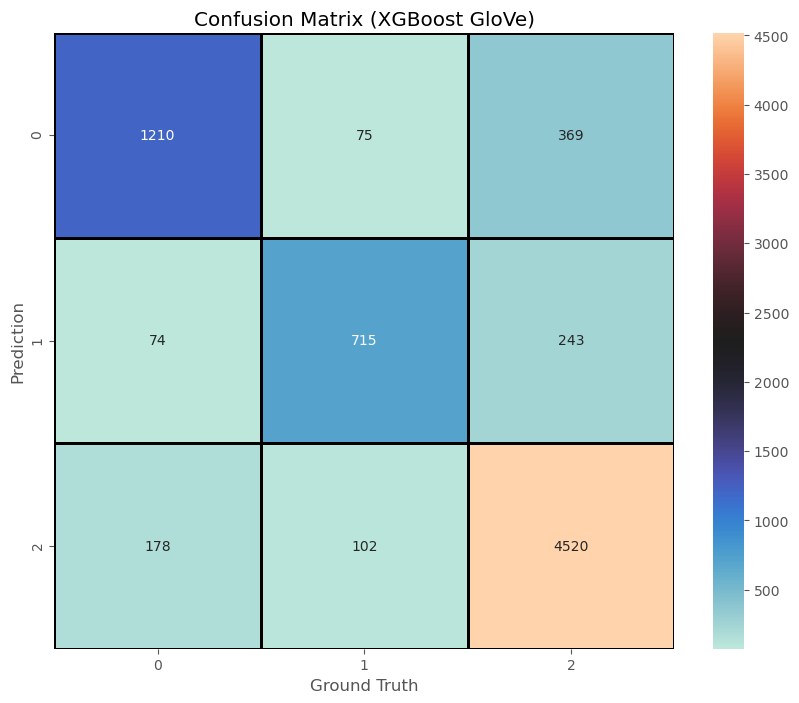

In [96]:
cm = confusion_matrix(y_test, XGB_glove_pred)

fig = plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='icefire', linecolor='black', linewidths=1, fmt='d')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title('Confusion Matrix (XGBoost GloVe)')

### LSTM Deep Learning Models

#### Embeddings from Corpus

In [10]:
# data preparation for deep learning

max_words = 1500
max_len = 500
num_classes = 3

X = df['Translated_Review'].apply(clean_text)
X = X.apply(remove_emoji)
tokenizer = Tokenizer(num_words=max_words, split=' ')
tokenizer.fit_on_texts(X.values)
X_seq = tokenizer.texts_to_sequences(X.values)
X_pad = pad_sequences(X_seq, maxlen=max_len)
word_index = tokenizer.word_index

le = LabelEncoder()
y = le.fit_transform(df['Sentiment'])
y_enc = tf.keras.utils.to_categorical(y, num_classes=num_classes, dtype='float32')

X_train, X_val, y_train, y_val = train_test_split(X_pad, y_enc, stratify=y, test_size=0.2, random_state=108, shuffle=True)


In [11]:
# create embedding matrix for words in dataset

embeddings_matrix = np.zeros((len(word_index) + 1, 300))

for word, i in tqdm(word_index.items()):
    embeddings_vector = word_index.get(word)
    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector

100%|██████████| 23515/23515 [00:00<00:00, 500777.14it/s]


In [99]:
embeddings_matrix.shape

(23516, 300)

In [12]:
# set parameters

batch_size = 64
epochs = 5
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2)
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [13]:
# build model

model_1 = Sequential()
model_1.add(Embedding(len(word_index)+1, embeddings_matrix.shape[1], weights=[embeddings_matrix], input_length=max_len))
model_1.add(SpatialDropout1D(0.3))
model_1.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))
model_1.add(Dense(1024, activation='relu'))
model_1.add(Dropout(0.6))
model_1.add(Dense(3))
model_1.add(Dropout(0.6))
model_1.add(Activation('softmax'))

model_1.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          7054800   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 500, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 600)               1442400   
_________________________________________________________________
dense (Dense)                (None, 1024)              615424    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
_________________________________________________________________
dropout_1 (Dropout)          (None, 3)                 0

In [14]:
# fit model

history_1 = model_1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), 
                        callbacks=[learning_rate_reduction, early_stop])

Epoch 1/5
468/468 [==============================] - 5931s 13s/step - loss: 1.1315 - accuracy: 0.4139 - val_loss: 0.9164 - val_accuracy: 0.6574
Epoch 2/5
468/468 [==============================] - 5552s 12s/step - loss: 0.9919 - accuracy: 0.4174 - val_loss: 0.9367 - val_accuracy: 0.6412
Epoch 3/5
468/468 [==============================] - 5420s 12s/step - loss: 0.9892 - accuracy: 0.4216 - val_loss: 0.9347 - val_accuracy: 0.6412


In [15]:
# save model and weights to disk

model_1_json = model_1.to_json()
with open('model_1.json', 'w') as json_file:
    json_file.write(model_1_json)

model_1.save_weights('model_1.h5')

In [16]:
# load model and weights from disk

json_file = open('model_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model_1 = tf.keras.models.model_from_json(loaded_model_json)
loaded_model_1.load_weights('model_1.h5')

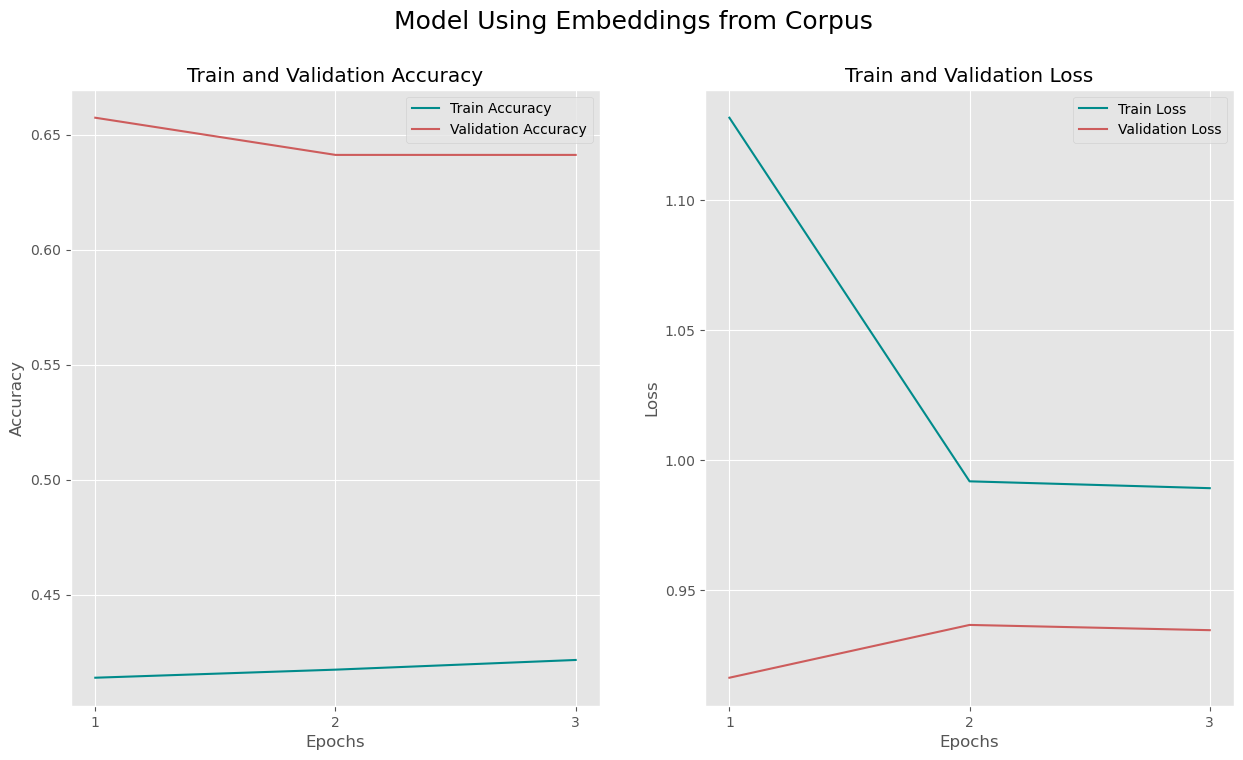

In [18]:
# plot accuracy and loss for training and validation

acc_1 = history_1.history['accuracy']
val_acc_1 = history_1.history['val_accuracy']
loss_1 = history_1.history['loss']
val_loss_1 = history_1.history['val_loss']

epochs_range = np.arange(1, 4, 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

ax1.plot(epochs_range, acc_1, label='Train Accuracy', color='darkcyan')
ax1.plot(epochs_range, val_acc_1, label='Validation Accuracy', color='indianred')
ax1.set_xticks(epochs_range)
ax1.set_title('Train and Validation Accuracy')
ax1.legend(loc='best')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

ax2.plot(epochs_range, loss_1, label='Train Loss', color='darkcyan')
ax2.plot(epochs_range, val_loss_1, label='Validation Loss', color='indianred')
ax2.set_xticks(epochs_range)
ax2.set_title('Train and Validation Loss')
ax2.legend(loc='best')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')

fig.suptitle('Model Using Embeddings from Corpus', fontsize=18)

plt.savefig('Model Corpus Accuracy and Loss.png')

plt.show()

#### Embeddings from GloVe

In [21]:
# create embeddings matrix for GloVe vectors

embeddings_matrix_glove = np.zeros((len(word_index) + 1, 300))

for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix_glove[i] = embedding_vector

100%|██████████| 23515/23515 [00:00<00:00, 372379.04it/s]


In [22]:
# build model

model_2 = Sequential()
model_2.add(Embedding(len(word_index)+1, embeddings_matrix.shape[1], weights=[embeddings_matrix_glove], input_length=max_len))
model_2.add(SpatialDropout1D(0.3))
model_2.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))
model_2.add(Dense(1024, activation='relu'))
model_2.add(Dropout(0.6))
model_2.add(Dense(3))
model_2.add(Dropout(0.6))
model_2.add(Activation('softmax'))

model_2.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          7054800   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 500, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600)               1442400   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              615424    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3075      
_________________________________________________________________
dropout_3 (Dropout)          (None, 3)                

In [23]:
# fit model

history_2 = model_2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), 
                        callbacks=[learning_rate_reduction, early_stop])

Epoch 1/5
468/468 [==============================] - 5843s 12s/step - loss: 0.8627 - accuracy: 0.5053 - val_loss: 0.3883 - val_accuracy: 0.8739
Epoch 2/5
468/468 [==============================] - 5379s 11s/step - loss: 0.7260 - accuracy: 0.5325 - val_loss: 0.4016 - val_accuracy: 0.8768
Epoch 3/5
468/468 [==============================] - 8445s 18s/step - loss: 0.7574 - accuracy: 0.5133 - val_loss: 0.4727 - val_accuracy: 0.7680


In [24]:
# save model and weights to disk

model_2_json = model_2.to_json()
with open('model_2.json', 'w') as json_file:
    json_file.write(model_2_json)

model_2.save_weights('model_2.h5')

In [25]:
# load model and weights from disk

json_file = open('model_2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model_2 = tf.keras.models.model_from_json(loaded_model_json)
loaded_model_2.load_weights('model_2.h5')

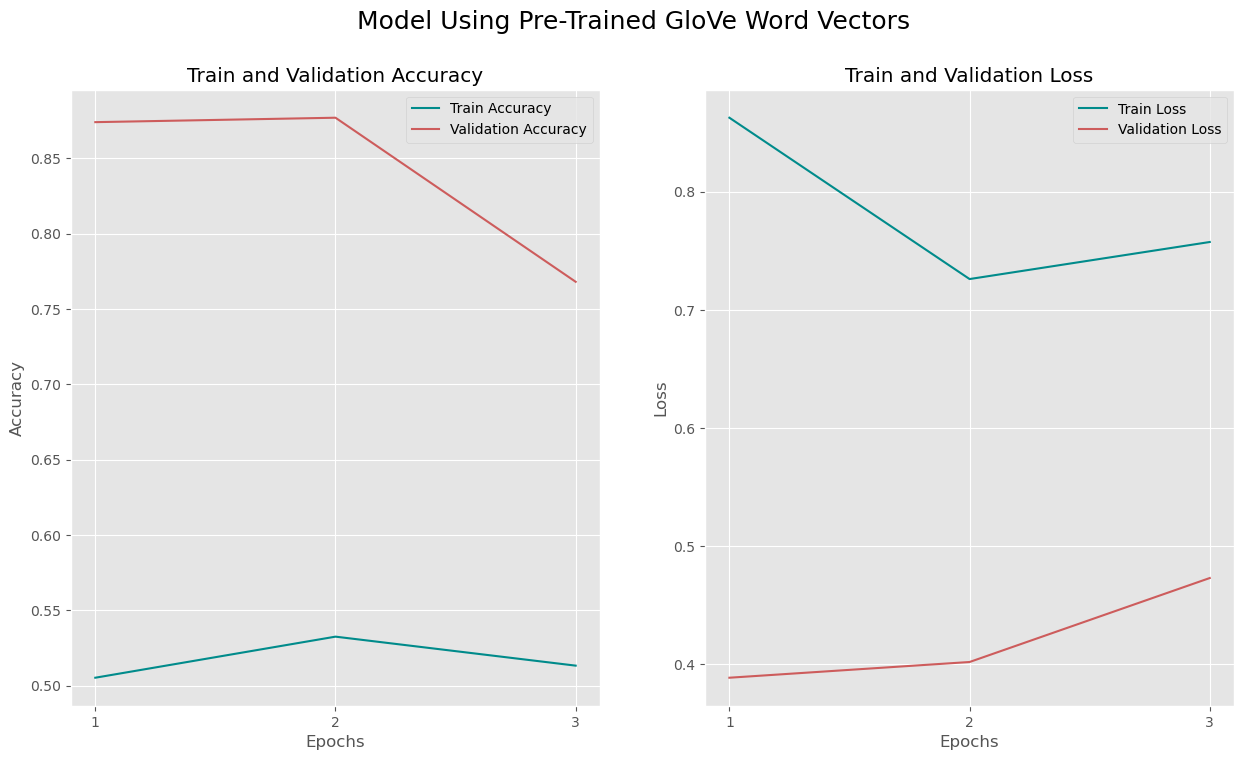

In [26]:
# plot accuracy and loss for training and validation

acc_2 = history_2.history['accuracy']
val_acc_2 = history_2.history['val_accuracy']
loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']

epochs_range = np.arange(1, 4, 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

ax1.plot(epochs_range, acc_2, label='Train Accuracy', color='darkcyan')
ax1.plot(epochs_range, val_acc_2, label='Validation Accuracy', color='indianred')
ax1.set_xticks(epochs_range)
ax1.set_title('Train and Validation Accuracy')
ax1.legend(loc='best')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

ax2.plot(epochs_range, loss_2, label='Train Loss', color='darkcyan')
ax2.plot(epochs_range, val_loss_2, label='Validation Loss', color='indianred')
ax2.set_xticks(epochs_range)
ax2.set_title('Train and Validation Loss')
ax2.legend(loc='best')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')

fig.suptitle('Model Using Pre-Trained GloVe Word Vectors', fontsize=18)

plt.savefig('Model GloVe.png')

plt.show()